# Lidar segmentation and curve fitting

In [1]:
# import cvxpy as cp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import time
from sklearn.cluster import KMeans, DBSCAN
import os

## Load and visualize data

In [2]:
cwd = os.getcwd()
data_folder = cwd + os.sep + 'data' + os.sep

def load_scan_data(data_file: str):
    scan_data = np.loadtxt(data_file, delimiter=',')
    angles = scan_data[:, 0]
    ranges = scan_data[:, 1]
    return angles, ranges
    
def load_odom_data(pos_file: str):
    pose = np.loadtxt(pos_file, delimiter=',')
    ego_pos = pose[:2]
    ego_yaw = pose[2]
    return ego_pos, ego_yaw
    
head_angles, head_ranges = load_scan_data(data_folder + 'ego_scan.csv')
trail_angles, trail_ranges = load_scan_data(data_folder + 'opp_scan.csv')

head_pos, head_yaw = load_odom_data(data_folder + 'ego_pose.csv')
trail_pos, trail_yaw = load_odom_data(data_folder + 'opp_pose.csv')

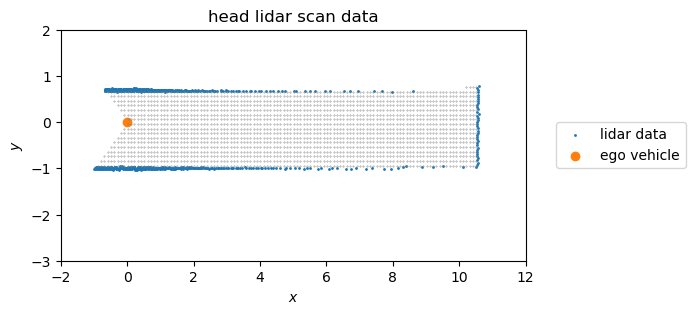

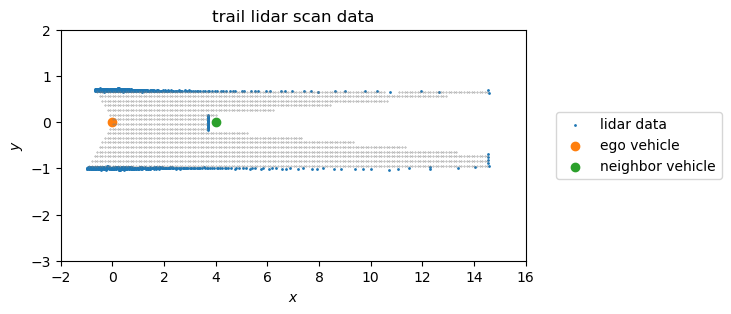

In [3]:
def plot_scan(angles, ranges, title: str, neighbor_rel_pos = np.array([0, 0])):
    x = ranges * np.cos(angles)
    y = ranges * np.sin(angles)
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = np.min(y)
    y_max = np.max(y)
    
    plt.figure(figsize=(6, 3))
    plt.scatter(x, y, s=1, label='lidar data')
    plt.scatter(0, 0, label='ego vehicle')
    if (neighbor_rel_pos != 0.).any():
        plt.scatter(neighbor_rel_pos[0], neighbor_rel_pos[1], label='neighbor vehicle')
    plt.title(title)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.xlim([np.floor(x_min) - 1, np.ceil(x_max) + 1])
    plt.ylim([np.floor(y_min) - 1, np.ceil(y_max) + 1])
    plt.legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

def plot_points_in_path(path, x_min, x_max, y_min, y_max):
    for x in np.arange(x_min, x_max, 0.1):
        for y in np.arange(y_min, y_max, 0.1):
            if path.contains_point(np.array([x, y])):
                plt.scatter(x, y, s=0.1, color='gray')

# visualize points within the lidar scan

head_x = head_ranges * np.cos(head_angles)
head_x_min, head_x_max = np.min(head_x), np.max(head_x)
head_y = head_ranges * np.sin(head_angles)
head_y_min, head_y_max = np.min(head_y), np.max(head_y)
head_pc = np.c_[head_x, head_y]

plot_scan(head_angles, head_ranges, 'head lidar scan data')
head_path = matplotlib.path.Path(np.r_[np.array([[0, 0]]), head_pc, np.array([[0, 0]])])
plot_points_in_path(head_path, head_x_min, head_x_max, head_y_min, head_y_max)

trail_x = trail_ranges * np.cos(trail_angles)
trail_x_min, trail_x_max = np.min(trail_x), np.max(trail_x)
trail_y = trail_ranges * np.sin(trail_angles)
trail_y_min, trail_y_max = np.min(trail_y), np.max(trail_y)
trail_pc = np.c_[trail_x, trail_y]

plot_scan(trail_angles, trail_ranges, 'trail lidar scan data', neighbor_rel_pos = head_pos - trail_pos)
trail_path = matplotlib.path.Path(np.r_[np.array([[0, 0]]), trail_pc, np.array([[0, 0]])])
plot_points_in_path(trail_path, trail_x_min, trail_x_max, trail_y_min, trail_y_max)

## Prepare data for clustering

In [4]:
# combine the x and y values into position matrix
xy = np.stack((head_x, head_y), axis = 1)

# segment out points more than radius meters away
radius = 2.0
# buffered_x = [x for [x,y] in xy if sqrt(pow(x,2)+pow(y,2)) <= radius]
# buffered_y = [y for [x,y] in xy if sqrt(pow(x,2)+pow(y,2)) <= radius]
# buffered_xy = np.stack((buffered_x, buffered_y), axis = 1)
buffered_xy = xy[np.linalg.norm(xy, axis=1) <= radius]
buffered_x = buffered_xy[:, 0]
buffered_y = buffered_xy[:, 1]

## Functions to visualize clusters

In [5]:
def plotClusters(labels):
    # plot clusters in different colors
    plt.figure(figsize=(6, 3))
    plt.scatter(0, 0, label='ego vehicle')
    plt.scatter(buffered_x, buffered_y, c=labels, s=1, label='lidar data')
    plt.title('Head Lidar Scan with Clustering and Radius Buffer')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.legend(bbox_to_anchor = (1.05, 0.5), loc='center left')
    plt.show()


def getClusterData(labels, n_clusters):
    # return x and y values from n clusters of data
    clusters = []
    for n in range(n_clusters):
        # cluster_x = [buffered_xy[i][0] for i in range(len(buffered_xy)) if labels[i] == n]
        # cluster_y = [buffered_xy[i][1] for i in range(len(buffered_xy)) if labels[i] == n]
        cluster_x = buffered_xy[labels == n, 0]
        cluster_y = buffered_xy[labels == n, 1]
        
        clusters.append(cluster_x)
        clusters.append(cluster_y)
    return clusters


def plotBestFit(top_line, bottom_line, path):
    # plot lines of best fit
    plt.figure(figsize=(6, 3))
    plt.scatter(0, 0, label='ego vehicle')
    plt.plot(buffered_x, top_line, color='purple', linestyle='-', linewidth=2)
    plt.plot(buffered_x, bottom_line, color='yellow', linestyle='-', linewidth=2)
    plt.plot(buffered_x, path, color='steelblue', linestyle='--', linewidth=2)
    plt.title('Best Fit with Clustering and Radius Buffer')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.legend(bbox_to_anchor = (1.05, 0.5), loc='center left')
    plt.show()

## KMeans Clustering on nearby lidar points

K-means time: 0.09909772872924805


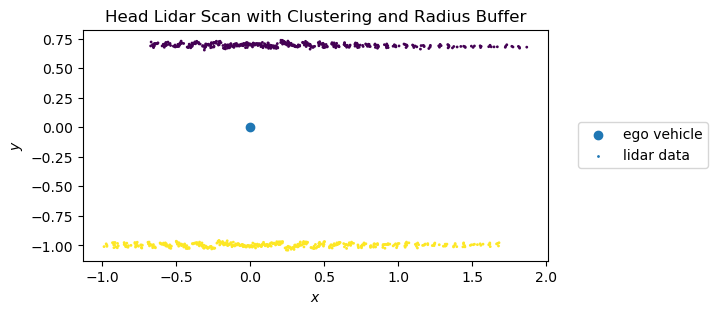

In [6]:
# get centroids for clustering
centroid_1 = xy[np.nonzero(np.isclose(head_angles, np.pi/2, atol=.001))]
centroid_2 = xy[np.nonzero(np.isclose(head_angles, -np.pi/2, atol=.001))]
centroids = np.r_[centroid_1, centroid_2]

# Cluster using KMeans
start = time.time()
kmeans = KMeans(init=centroids, n_clusters=2, n_init=1).fit(buffered_xy)
end = time.time()
print("K-means time:", end-start)

# Separate data into clusters x and y
kmeans_clusters = getClusterData(kmeans.labels_, 2)
km_cluster0_x = kmeans_clusters[0]
km_cluster0_y = kmeans_clusters[1]
km_cluster1_x = kmeans_clusters[2]
km_cluster1_y = kmeans_clusters[3]

# Plot Kmeans clusters
plotClusters(kmeans.labels_)

## Fitting K-Means clustering

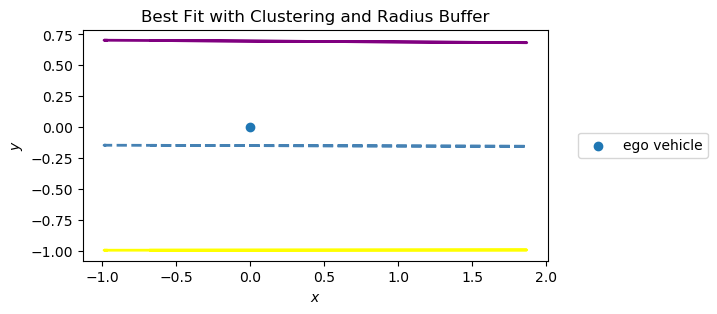

In [7]:
# Find line of best fit
a0, b0 = np.polyfit(km_cluster0_x, km_cluster0_y, 1)
a1, b1 = np.polyfit(km_cluster1_x, km_cluster1_y, 1)

cluster0_bf = [a0*x+b0 for x in buffered_x] 
cluster1_bf = [a1*x+b1 for x in buffered_x] 
path_bf = [(a1*x+b1+a0*x+b0)/2 for x in buffered_x]

# Plot lines of best fit
plt.figure(figsize=(6, 3))
plt.scatter(0, 0, label='ego vehicle')
plt.plot(buffered_x, cluster0_bf, color='purple', linestyle='-', linewidth=2)
plt.plot(buffered_x, cluster1_bf, color='yellow', linestyle='-', linewidth=2)
plt.plot(buffered_x, path_bf, color='steelblue', linestyle='--', linewidth=2)
plt.title('Best Fit with Clustering and Radius Buffer')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend(bbox_to_anchor = (1.05, 0.5), loc='center left')
plt.show()

## DBSCAN Clustering on nearby lidar points

DBSCAN time: 0.0019769668579101562


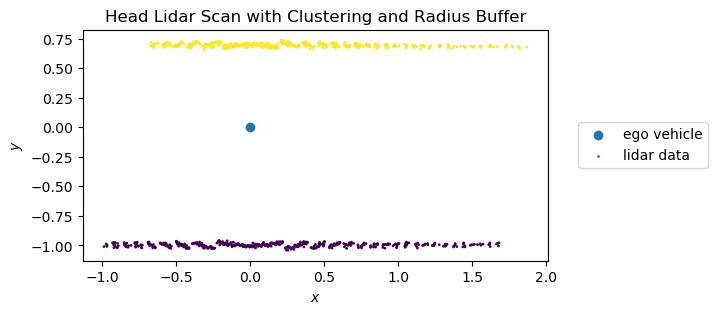

In [8]:
# Cluster using KMeans
start = time.time()
dbscan = DBSCAN(eps=0.12, algorithm='ball_tree', metric='euclidean').fit(buffered_xy)
end = time.time()

# Separate data into clusters x and y
db_clusters = getClusterData(dbscan.labels_, 2)
db_cluster0_x = db_clusters[0]
db_cluster0_y = db_clusters[1]
db_cluster0_xy = np.stack((db_cluster0_x, db_cluster0_y), axis = 1)
db_cluster1_x = db_clusters[2]
db_cluster1_y = db_clusters[3]
db_cluster1_xy = np.stack((db_cluster1_x, db_cluster1_y), axis = 1)
print("DBSCAN time:", end-start)

# Plot Kmeans clusters
plotClusters(dbscan.labels_)

## Least Squares Regression on DBSCAN Clustered data
Aim: create a straight line that minimizes the variance of the associated equations

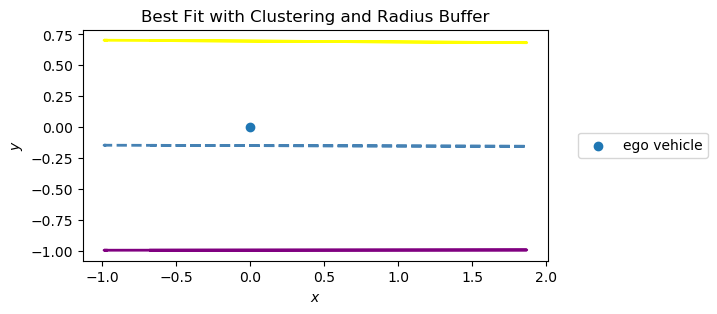

In [9]:
# Function for Least Squares Regression
# def getCoeffs(cluster_x, cluster_y, cluster_xy):
#     # get variables
#     sum_x = sum(cluster_x)
#     sum_y = sum(cluster_y)
#     sum_x2 = sum([pow(x,2) for x in cluster_x])
#     sum_xy = sum([x*y for x, y in cluster_xy])
#     n = len(cluster_xy)

#     # calculate slope
#     m = (n*sum_xy - sum_x*sum_y)/(n*sum_x2 - pow(sum_x,2))

#     # calculate intercept
#     b = (sum_y -m*sum_x)/n

#     return m, b

# # get coeffs for clusters
# m0, b0 = getCoeffs(db_cluster0_x, db_cluster0_y, db_cluster0_xy)
# m1, b1 = getCoeffs(db_cluster1_x, db_cluster1_y, db_cluster1_xy)

# db_c0_line = [m0*x+b0 for x in buffered_x] 
# db_c1_line = [m1*x+b1 for x in buffered_x]
# db_path_line = [(m1*x+b1+m0*x+b0)/2 for x in buffered_x]

# if you use np arrays instead of lists, can just do the below two lines 
# instead of using list comprehensions
# db_c0_line = m0 * buffered_x + b0
# db_c1_line = m1 * buffered_x + b1
# db_path_line = (m1 + m0) / 2 * buffered_x + (b1 + b0) / 2

# but since I switched to using the numpy Polynomial class since I'm messing 
# with the node, I will just do:
domain = np.array([buffered_x[0], buffered_x[-1]])
poly_0 = Polynomial.fit(db_cluster0_x, db_cluster0_y, deg=1).convert(domain=domain)
poly_1 = Polynomial.fit(db_cluster1_x, db_cluster1_y, deg=1).convert(domain=domain)
poly_centerline = (poly_0 + poly_1) / 2.

db_c0_line = poly_0(buffered_x)
db_c1_line = poly_1(buffered_x)
db_path_line = poly_centerline(buffered_x)

# Plot lines of best fit
plotBestFit(db_c0_line, db_c1_line, db_path_line)